# Pipeline for High-z Radio Galaxies 08: Understanding application of full pipeline on confusion matrices

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import mpl_scatter_density
import squarify
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

---

## Reading data

Flags.

In [4]:
save_plot_flag      = True
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False
use_calibration     = True
plot_cm_MQC_types   = False

In [5]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS'
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies). For most plots, only use False

In [6]:
if used_area == 'HETDEX':
    HETDEX_subset = 'Validation'  # Validation, Training, Test, Test+Train, Calibration

In [7]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [8]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                       'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag',\
                       'NUVmag', 'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                       'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect', 'LoLSS_detect']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                       'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag',\
                       'NUVmag', 'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [9]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [10]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

In [11]:
print(f'Using data from {used_area}')

Using data from S82


Create features with class and combined redshift.

In [12]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

For HETDEX, split data on training, test, validation.

In [13]:
if used_area == 'HETDEX':
    if use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
            (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
    elif not use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
    print('Shape of used data in HETDEX')
    print('-' * 65)
    print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
    print(f'Training data:                                    {train_df.shape}')
    print(f'Testing data:                                     {test_df.shape}')
    if use_calibration:
        print(f'Calibration data:                                 {calibration_df.shape}')
    print(f'Validation data:                                  {validation_df.shape}')
    print('-' * 65)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                        'Validation': validation_df, 'Calibration': calibration_df}
    full_catalog_df = selected_dataset[HETDEX_subset]

For non HETDEX, obtain known and unknown sources sub-samples.

In [14]:
if used_area != 'HETDEX':
    filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                       (full_catalog_df.loc[:, 'class'] == 1) |\
                       (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
    full_catalog_df  = full_catalog_df.loc[filter_confirmed]

Discard minor features.

In [15]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])
unknown_cat_df                      = unknown_cat_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [16]:
if use_unknown:
    full_catalog_df = unknown_cat_df

In [17]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (3304, 89)
--------------------------------------------------
Thus, it has 3,304 sources and 89 features.


---

### Load models

In [18]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [19]:
if use_zeroth_model:
    threshold_star_logit = np.log(gv.cal_star_thresh  / (1 - gv.cal_star_thresh))
threshold_AGN_logit      = np.log(gv.cal_AGN_thresh   / (1 - gv.cal_AGN_thresh))
threshold_radio_logit    = np.log(gv.cal_radio_thresh / (1 - gv.cal_radio_thresh))

In [20]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=gv.star_thresh, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
    pred_probs      = cal_star_clf.predict(full_catalog_df.loc[:, 'Score_no_star'])
    cal_class       = np.array(pred_probs < (1 - gv.cal_star_thresh)).astype(int)
    full_catalog_df['Prob_no_star']  = pred_probs
    full_catalog_df['pred_star_cal'] = cal_class
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1
    full_catalog_df['Prob_no_star']  = 1
    full_catalog_df['pred_star_cal'] = 0

In [21]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)
pred_probs = cal_AGN_gal_clf.predict(full_catalog_df.loc[:, 'Score_AGN'])
cal_class  = np.array(pred_probs >= gv.cal_AGN_thresh).astype(int)
full_catalog_df['Prob_AGN']       = pred_probs
full_catalog_df['pred_class_cal'] = cal_class

In [22]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)
pred_probs      = cal_radio_det_clf.predict(full_catalog_df.loc[:, 'Score_radio'])
cal_class       = np.array(pred_probs >= gv.cal_radio_thresh).astype(int)
full_catalog_df['Prob_radio']     = pred_probs
full_catalog_df['pred_radio_cal'] = cal_class

In [23]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)

In [24]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=8)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)

In [25]:
full_catalog_df.loc[:, ['class', 'pred_class', 'LOFAR_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,LOFAR_detect,pred_radio,Z,pred_Z
count,3304.000000,3304.000000,3304.000000,3304.000000,3304.000000,3304.000000
mean,0.847458,0.744855,0.316283,0.391646,1.323084,1.500736
std,0.359600,0.436009,0.465095,0.488192,0.880608,0.823235
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.028000
25%,1.000000,0.000000,0.000000,0.000000,0.624043,0.808050
50%,1.000000,1.000000,0.000000,0.000000,1.209500,1.572150
75%,1.000000,1.000000,1.000000,1.000000,1.895500,2.129000
max,1.000000,1.000000,1.000000,1.000000,6.780000,4.684700


In [26]:
full_catalog_df['is_rAGN']   = (np.array(full_catalog_df.loc[:, 'class']        == 1) &\
                                np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)).astype(int)
full_catalog_df['pred_rAGN'] = (np.array(full_catalog_df.loc[:, 'pred_star']    == 0) &\
                                np.array(full_catalog_df.loc[:, 'pred_class']   == 1) &\
                                np.array(full_catalog_df.loc[:, 'pred_radio']   == 1)).astype(int)
full_catalog_df['pred_rAGN_prob'] = (np.array(full_catalog_df.loc[:, 'pred_star_cal']  == 0) &\
                                     np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                                     np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1)).astype(int)

In [27]:
np.sum(full_catalog_df.loc[:, 'is_rAGN'])

934

In [28]:
np.sum(np.array(full_catalog_df.loc[:, 'class']      == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))

934

In [29]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'pred_class_cal']      == 1) &\
                            np.array(full_catalog_df.loc[:, 'pred_radio_cal']    == 1)
filter_AGN_p            = np.array(full_catalog_df.loc[:, 'pred_class_cal']      == 1)
filter_radio_p          = np.array(full_catalog_df.loc[:, 'pred_radio_cal']      == 1)
num_AGN_p               = np.sum(filter_AGN_p)
num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0))
num_radio_p             = np.sum(filter_radio_p)
num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

#### Add columns with classes as shown by TYPE column in MQC

MQC v7.4d says:

Legend of type/class:  
     ``Q = QSO, type-I broad-line core-dominated, 792372 of these.``  
     ``A = AGN, type-I Seyferts/host-dominated, 41983 of these.``  
     ``B = BL Lac type object, 2744 of these.``  
     ``L = lensed quasar extra image, only 66 of these in this optical data.``  
     ``K = NLQSO, type-II narrow-line core-dominated, 5798 of these.``  
     ``N = NLAGN, type-II Seyferts/host-dominated, 39366 of these.  Includes an``  
                ``unquantified residue of legacy NELGs/ELGs/LINERs.``  
     ``R = radio association displayed.``  
     ``X = X-ray association displayed.``  
     ``2 = double radio lobes displayed (declared by data-driven algorithm).``  

QSO candidates (type starting with ``R/X/2``)  
Fully classified object (type starting with ``Q/A/B/K/N/L``)

In [30]:
MQC_types = ['Q', 'A', 'B', 'K', 'N', 'L', 'R', 'X', '2']
for type_val in MQC_types:
    full_catalog_df[f'is_{type_val}'] = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)).astype(int)

### Create confusion matrices and scores for all individual TYPEs of sources

In [31]:
cm_mat_MQC_filts = {}
cm_mat_MQC       = {}
MCC_MQC          = {}
ACC_MQC          = {}
Fb_MQC           = {}
Recall_MQC       = {}

In [32]:
cm_mat_AGN_filter       = np.array([[(np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class_cal'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class_cal'] == 1.0))],\
                                    [(np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class_cal'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class_cal'] == 1.0))]])

cm_mat_AGN_large_filter = np.array([[(np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class_cal'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class_cal'] == 0.5)),\
                                     (np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class_cal'] == 1.0))],\
                                    [(np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['pred_class_cal'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['pred_class_cal'] == 0.5)),\
                                     (np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['pred_class_cal'] == 1.0))],\
                                    [(np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class_cal'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class_cal'] == 0.5)),\
                                     (np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class_cal'] == 1.0))]])

In [33]:
cm_mat_radio_filter     = np.array([[(np.array(full_catalog_df.loc[filter_AGN_p, 'LOFAR_detect'] == 0) &\
                                      np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio_cal'] == 0.0)),\
                                     (np.array(full_catalog_df.loc[filter_AGN_p, 'LOFAR_detect'] == 0) &\
                                      np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio_cal'] == 1.0))],\
                                    [(np.array(full_catalog_df.loc[filter_AGN_p, 'LOFAR_detect'] == 1) &\
                                      np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio_cal'] == 0.0)),\
                                     (np.array(full_catalog_df.loc[filter_AGN_p, 'LOFAR_detect'] == 1) &\
                                      np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio_cal'] == 1.0))]])

cm_mat_rAGN_filter      = np.array([[(np.array(full_catalog_df['is_rAGN'] == 0) & np.array(full_catalog_df['pred_rAGN_prob'] == 0.0)),\
                                     (np.array(full_catalog_df['is_rAGN'] == 0) & np.array(full_catalog_df['pred_rAGN_prob'] == 1.0))],\
                                    [(np.array(full_catalog_df['is_rAGN'] == 1) & np.array(full_catalog_df['pred_rAGN_prob'] == 0.0)),\
                                     (np.array(full_catalog_df['is_rAGN'] == 1) & np.array(full_catalog_df['pred_rAGN_prob'] == 1.0))]])

In [34]:
cm_mat_AGN        = np.array([[np.sum(cm_mat_AGN_filter[0, 0]),       np.sum(cm_mat_AGN_filter[0, 1])],\
                              [np.sum(cm_mat_AGN_filter[1, 0]),       np.sum(cm_mat_AGN_filter[1, 1])]])

cm_mat_AGN_large  = np.array([[np.sum(cm_mat_AGN_large_filter[0, 0]), np.sum(cm_mat_AGN_large_filter[0, 1]), np.sum(cm_mat_AGN_large_filter[0, 2])],\
                              [np.sum(cm_mat_AGN_large_filter[1, 0]), np.sum(cm_mat_AGN_large_filter[1, 1]), np.sum(cm_mat_AGN_large_filter[1, 2])],\
                              [np.sum(cm_mat_AGN_large_filter[2, 0]), np.sum(cm_mat_AGN_large_filter[2, 1]), np.sum(cm_mat_AGN_large_filter[2, 2])]])

In [35]:
cm_mat_radio      = np.array([[np.sum(cm_mat_radio_filter[0, 0]),     np.sum(cm_mat_radio_filter[0, 1])],\
                              [np.sum(cm_mat_radio_filter[1, 0]),     np.sum(cm_mat_radio_filter[1, 1])]])

cm_mat_rAGN       = np.array([[np.sum(cm_mat_rAGN_filter[0, 0]),      np.sum(cm_mat_rAGN_filter[0, 1])],\
                              [np.sum(cm_mat_rAGN_filter[1, 0]),      np.sum(cm_mat_rAGN_filter[1, 1])]])

In [36]:
CM_filters = {'AGN': cm_mat_AGN_filter, 'AGN_large': cm_mat_AGN_large_filter,\
              'radio': cm_mat_radio_filter, 'radio_AGN': cm_mat_rAGN_filter}

CM_sizes   = {'AGN': cm_mat_AGN, 'AGN_large': cm_mat_AGN_large,\
            'radio': cm_mat_radio, 'radio_AGN': cm_mat_rAGN}

#### Select classification for following plots

In [37]:
used_labels    = {'AGN': ['Galaxy', 'AGN'], 'AGN_large': ['Galaxy', 'Unknown', 'AGN'],\
                  'radio': ['No radio', 'Radio'], 'radio_AGN': ['No radio AGN', 'Radio AGN']}

In [38]:
used_classes   = 'AGN'
used_CM_filter = CM_filters[used_classes]  # AGN, radio, radio_AGN

#### Select sub-set to use (full, training, testing, validation)

In [39]:
for type_val in MQC_types:
    cm_mat_MQC_filts[type_val] = np.array([[(np.array(full_catalog_df[f'is_{type_val}'] == 0) &\
                                             np.array(full_catalog_df['pred_class_cal'] == 0.0)),\
                                            (np.array(full_catalog_df[f'is_{type_val}'] == 0) &\
                                             np.array(full_catalog_df['pred_class_cal'] == 1.0))],\
                                           [(np.array(full_catalog_df[f'is_{type_val}'] == 1) &\
                                             np.array(full_catalog_df['pred_class_cal'] == 0.0)),\
                                            (np.array(full_catalog_df[f'is_{type_val}'] == 1) &\
                                             np.array(full_catalog_df['pred_class_cal'] == 1.0))]])
    cm_mat_MQC[type_val]       = gf.conf_mat_func(full_catalog_df[f'is_{type_val}'], full_catalog_df['pred_class_cal'])
    # cm_mat_MQC[type_val]       = np.array([[np.sum(cm_mat_MQC_filts[type_val][0, 0] * used_CM_filter[0, 0]),\
    #                                         np.sum(cm_mat_MQC_filts[type_val][0, 1] * used_CM_filter[0, 1])],\
    #                                        [np.sum(cm_mat_MQC_filts[type_val][1, 0] * used_CM_filter[1, 0]),\
    #                                         np.sum(cm_mat_MQC_filts[type_val][1, 1] * used_CM_filter[1, 1])]])

    MCC_MQC[type_val]          = gf.MCC_from_CM(cm_mat_MQC[type_val])
    ACC_MQC[type_val]          = gf.ACC_from_CM(cm_mat_MQC[type_val])
    Fb_MQC[type_val]           = gf.Fb_from_CM(cm_mat_MQC[type_val])
    Recall_MQC[type_val]       = gf.Recall_from_CM(cm_mat_MQC[type_val])

In [40]:
MCC_AGN_all       = gf.MCC_from_CM(cm_mat_AGN)
ACC_AGN_all       = gf.ACC_from_CM(cm_mat_AGN)
Fb_AGN_all        = gf.Fb_from_CM(cm_mat_AGN)
Precision_AGN_all = gf.Precision_from_CM(cm_mat_AGN)
Recall_AGN_all    = gf.Recall_from_CM(cm_mat_AGN)

In [41]:
print('-' * 50)
print(f'Metrics for AGN detection in {used_area} dataset:')
if used_area == 'HETDEX':
    print(f'Subset used: {HETDEX_subset}')
print(f'Fb-score is                         F-\u03B2 = {Fb_AGN_all:.4f}')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_all:.4f}')
print(f'Precision is                       PREC = {Precision_AGN_all:.4f}')
print(f'Recall is                           TPR = {Recall_AGN_all:.4f}')
print(f'Accuracy is                         ACC = {ACC_AGN_all:.4f}')
print('-' * 50  + '\n')

--------------------------------------------------
Metrics for AGN detection in S82 dataset:
Fb-score is                         F-β = 0.9206
Matthews Correlation Coefficient is MCC = 0.6507
Precision is                       PREC = 0.9793
Recall is                           TPR = 0.8771
Accuracy is                         ACC = 0.8801
--------------------------------------------------



In [42]:
if plot_cm_MQC_types:
    for type_val in MQC_types:
        fig             = plt.figure(figsize=(8,6))
        ax1             = fig.add_subplot(111)
        
        _ = gf.plot_conf_mat(cm_mat_MQC[type_val], title=f'TYPE = {type_val}', axin=ax1, display_labels=[f'Non-{type_val}', f'{type_val}'], log_stretch=True)
        save_filename = f'confusion_matrix_{used_classes}_{type_val}_{used_area}.pdf'
        if used_area == 'HETDEX':
            save_filename = f'confusion_matrix_{used_classes}_{type_val}_{used_area}_{HETDEX_subset}.pdf'
        if save_plot_flag:
            plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
        plt.show()

---

### Use squarify

In [43]:
sizes_types_full   = []  # full dataset, no confusion matrix
used_types_full    = []
list_types         = ['Q', 'A', 'B', 'L', 'K', 'N']
for type_val in list_types:
    n_elems = np.sum(np.array(full_catalog_df[f'is_{type_val}'] == 1))
    if n_elems == 0:
        continue
    used_types_full.append(type_val)
    sizes_types_full.append(np.sum(np.array(full_catalog_df[f'is_{type_val}'] == 1)))

In [44]:
color_ll   = plt.get_cmap('cet_CET_L8', len(used_types_full))
color_list = [mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)]

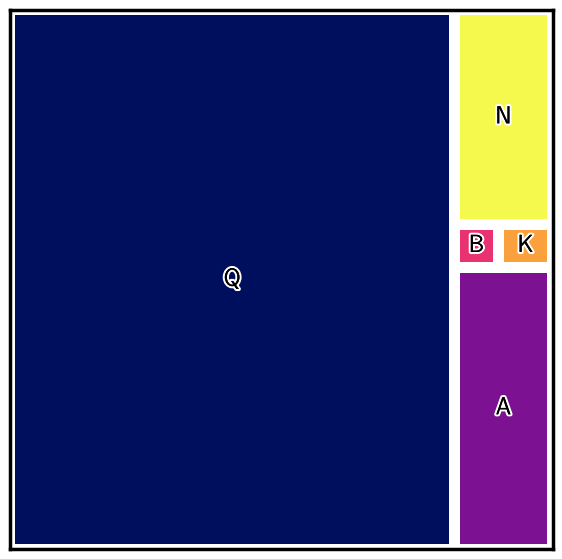

In [45]:
fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types_full, label=used_types_full, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

In [46]:
show_empty_flag = False

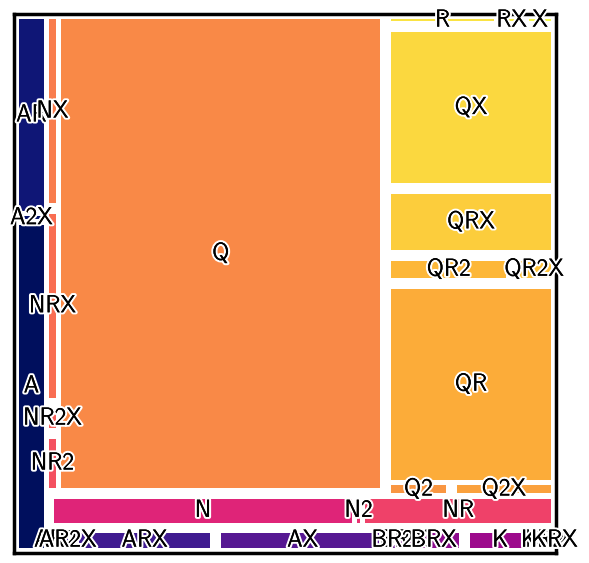

In [47]:
sizes_types   = []
list_types    = list(np.unique(full_catalog_df.loc[:, 'TYPE']))
if not show_empty_flag:
    list_types.remove('    ')
for type_val in list_types:
    sizes_types.append(np.sum(full_catalog_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)))

color_ll   = plt.get_cmap('cet_CET_L8', len(list_types))
color_list = [mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)]

if show_empty_flag:
    list_types[:] = ['0   ' if x=='    ' else x for x in list_types]

fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types, label=list_types, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

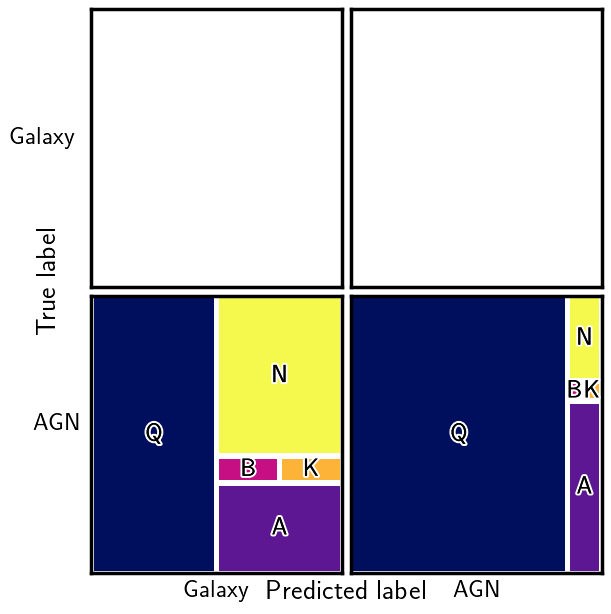

In [48]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3 * n_cols, 3 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.001, wspace=0.0)
axs             = {}

list_types    = ['Q', 'A', 'B', 'L', 'K', 'N']
color_ll      = plt.get_cmap('cet_CET_L8', len(list_types))
color_list    = {list_types[i]: mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs[count]     = fig.add_subplot(grid[count], xscale='linear', yscale='linear')
    
    list_types_tmp = ['Q', 'A', 'B', 'L', 'K', 'N']
    sizes_types    = []
    used_types     = []
    for type_val in list_types_tmp:
        n_sources  = np.sum(np.array(full_catalog_df[f'is_{type_val}'] == 1) & used_CM_filter[tuple(idx_ax)])
        if n_sources == 0:
            continue
        sizes_types.append(n_sources)
        used_types.append(type_val)
    
    color_list_tmp = [color_list[elem] for elem in used_types]
    
    sq_plt = squarify.plot(sizes_types, label=used_types, ax=axs[count], pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list_tmp)
    
    axs[count].get_xaxis().set_ticks([])
    axs[count].get_yaxis().set_ticks([])
    axs[count].tick_params(which='both', top=False, right=False,\
                           bottom=False, left=False, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

fig.supxlabel('Predicted label', fontsize=20, ha='center', x=0.57, y=0.002)
fig.supylabel('True label', fontsize=20, va='bottom', x=0.05, y=0.45)
# fig.suptitle('Predicted values', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'conf_matrix_treeplot_{used_classes}_MQC_TYPE_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'conf_matrix_treeplot_{used_classes}_MQC_TYPE_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

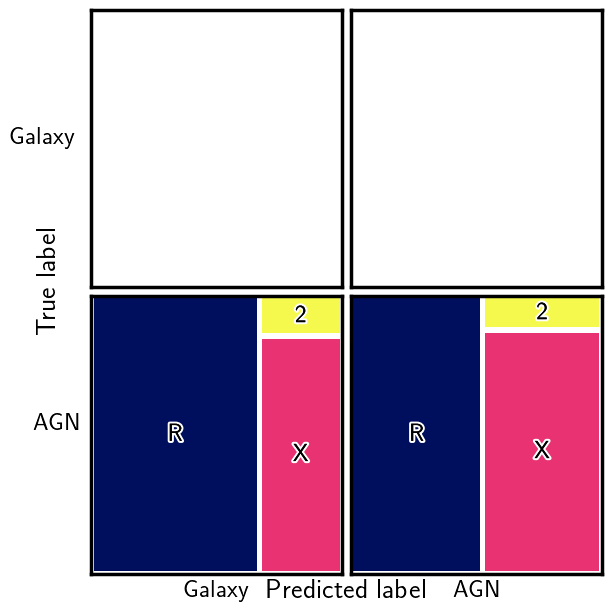

In [49]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3 * n_cols, 3 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.001, wspace=0.0)
axs             = {}

list_types    = ['R', 'X', '2']
color_ll      = plt.get_cmap('cet_CET_L8', len(list_types))
color_list    = {list_types[i]: mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs[count]     = fig.add_subplot(grid[count], xscale='linear', yscale='linear')
    
    list_types_tmp = ['R', 'X', '2']
    sizes_types    = []
    used_types     = []
    for type_val in list_types_tmp:
        n_sources  = np.sum(np.array(full_catalog_df[f'is_{type_val}'] == 1) & used_CM_filter[tuple(idx_ax)])
        if n_sources == 0:
            continue
        sizes_types.append(n_sources)
        used_types.append(type_val)
    
    color_list_tmp = [color_list[elem] for elem in used_types]
    
    sq_plt = squarify.plot(sizes_types, label=used_types, ax=axs[count], pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list_tmp)
    
    axs[count].get_xaxis().set_ticks([])
    axs[count].get_yaxis().set_ticks([])
    axs[count].tick_params(which='both', top=False, right=False,\
                           bottom=False, left=False, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

fig.supxlabel('Predicted label', fontsize=20, ha='center', x=0.57, y=0.004)
fig.supylabel('True label', fontsize=20, va='bottom', x=0.05, y=0.45)
# fig.suptitle('Predicted values', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'conf_matrix_treeplot_{used_classes}_MQC_TYPE_assoc_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'conf_matrix_treeplot_{used_classes}_MQC_TYPE_assoc_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

### Additional plots for confusion matrix

In [50]:
mag_cols_lim = {'W1mproPM': 20.13, 'W2mproPM': 19.81, 'Sint_LOFAR': 17.52, 'Total_flux_VLASS': 15.21,\
                    'TotalFlux_LoLSS': 12.91, 'Stotal_TGSS': 11.18, 'Fint_VLAS82': 17.86,\
                    'Flux_COSMOSVLA3': 21.25, 'W1mag': 19.6, 'W2mag': 19.34, 'W3mag': 16.67,\
                    'W4mag': 14.62, 'gmag': 23.3, 'rmag': 23.2, 'imag': 23.1, 'zmag': 22.3,\
                    'ymag': 21.4, 'FUVmag': 20.0, 'NUVmag': 21.0, 'FEP': 57.9, 'Jmag': 17.45,\
                    'Hmag': 17.24, 'Kmag': 16.59}  # Proper (5-sigma) limits

for key in mag_cols_lim:
    mag_cols_lim[key] = np.float32(mag_cols_lim[key])

In [51]:
bands_plot = ['FUVmag', 'NUVmag', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag',
              'Hmag', 'Kmag', 'W1mproPM', 'W2mproPM', 'W1mag', 'W2mag', 'W3mag', 'W4mag']

In [52]:
mag_cols_names   = {'W1mproPM': 'W1 (CW)', 'W2mproPM': 'W2 (CW)', 'Sint_LOFAR': 'LOFAR', 'Total_flux_VLASS': 'VLASS', 
                  'TotalFlux_LoLSS': 'LoLSS', 'Stotal_TGSS': 'TGSS', 'W1mag': 'W1 (AW)', 
                  'W2mag': 'W2 (AW)', 'W3mag': 'W3 (AW)', 'W4mag': 'W4 (AW)', 'gmag': 'g', 'rmag': 'r', 
                  'imag': 'i', 'zmag': 'z', 'ymag': 'y', 'FUVmag': 'FUV', 'NUVmag': 'NUV', 
                  'FEP': 'XMM', 'Jmag': 'J', 'Hmag': 'H', 'Kmag': 'K'}

Temporary plots, to obtain density maps of full dataset (all confirmed).

In [53]:
discard_imputed = False

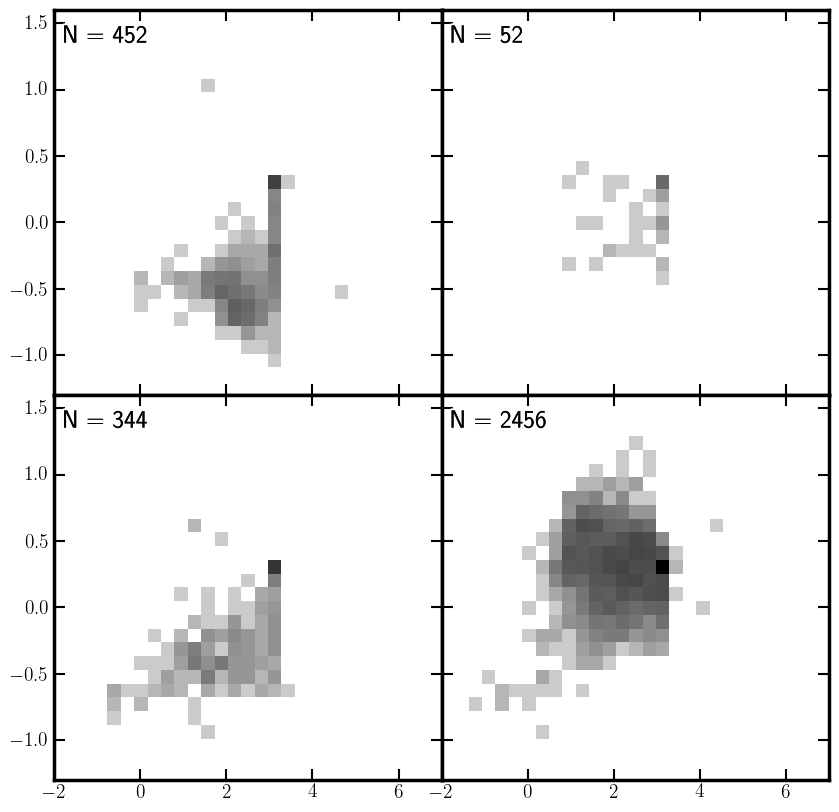

In [54]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(5 * n_cols, 5 * n_rows), constrained_layout=False)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs_temp        = {}

filt_plot       = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
                  np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])
filt_exist      = np.isfinite(full_catalog_df.loc[:, 'W1mproPM']) &\
                  np.isfinite(full_catalog_df.loc[:, 'W2mproPM']) &\
                  np.isfinite(full_catalog_df.loc[:, 'W3mag'])
if discard_imputed:
    filt_colours    = np.array(full_catalog_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                      np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                      np.array(full_catalog_df.loc[:, 'W3mag'] != mag_cols_lim['W3mag'])
if not discard_imputed:
    filt_colours    = np.ones_like(full_catalog_df.loc[:, 'W1mproPM']).astype(bool)
dens_CM_classes = {}

norm_dens       = ImageNormalize(vmin=0, vmax=4e2, stretch=LogStretch())

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # kwargs = {}
    # if count != 0:
    #     kwargs = {'sharex': axs_temp[0], 'sharex': axs_temp[0]}
    # axs_temp[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    if count == 0:
        axs_temp[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    if count != 0:
        axs_temp[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density',\
                                          sharex=axs_temp[0], sharey=axs_temp[0])
        
    x_axis_dens = (full_catalog_df[used_CM_filter[tuple(idx_ax)] * filt_colours * filt_exist]['W2mproPM'] -\
                   full_catalog_df[used_CM_filter[tuple(idx_ax)] * filt_colours * filt_exist]['W3mag'])
    y_axis_dens = (full_catalog_df[used_CM_filter[tuple(idx_ax)] * filt_colours * filt_exist]['W1mproPM'] -\
                   full_catalog_df[used_CM_filter[tuple(idx_ax)] * filt_colours * filt_exist]['W2mproPM'])
    n_sources   = np.sum(used_CM_filter[tuple(idx_ax)] * filt_colours * filt_exist)
    axs_temp[count].annotate(text=f'N = {n_sources}', xy=(0.02, 0.96), xycoords='axes fraction', fontsize=18,\
                            ha='left', va='top', path_effects=gf.pe2, zorder=11)
    if not ((len(x_axis_dens) == 0) | (len(y_axis_dens) == 0)):
        dens_CM_classes[count] = axs_temp[count].scatter_density(x_axis_dens, y_axis_dens,\
                                                             cmap=plt.get_cmap('cet_gray_r'), zorder=0,\
                                                             dpi=9, alpha=1.0, norm=norm_dens)
    if ((len(x_axis_dens) == 0) | (len(y_axis_dens) == 0)):
        dens_CM_classes[count] = None
    if count == 0:
        x_lims = (axs_temp[count].get_xlim()[0] - 0.2, axs_temp[count].get_xlim()[1] + 0.2)
        y_lims = (axs_temp[count].get_ylim()[0] - 0.2, axs_temp[count].get_ylim()[1] + 0.2)
        
    axs_temp[count].tick_params(which='both', top=True, right=True,\
                            bottom=True, left=True, direction='in')
    axs_temp[count].tick_params(axis='both', which='major', labelsize=14)
    axs_temp[count].tick_params(axis='both', which='minor', labelsize=14)
    axs_temp[count].tick_params(which='major', length=8, width=1.5)
    axs_temp[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs_temp[count].spines.values(), linewidth=2.5)
    plt.setp(axs_temp[count].spines.values(), linewidth=2.5)

plt.setp(axs_temp[0].get_xticklabels(), visible=False)
plt.setp(axs_temp[1].get_yticklabels(), visible=False)
plt.setp(axs_temp[1].get_xticklabels(), visible=False)
plt.setp(axs_temp[3].get_yticklabels(), visible=False)

axs_temp[0].set_xlim(left=-2, right=7)
axs_temp[0].set_ylim(bottom=-1.3, top=1.6)
axs_temp[0].set_aspect('auto', 'datalim')
#plt.close(fig_temp)

In [55]:
num_contour_levels = 10
type_of_levels     = 'log'  # 'log', 'linear'
if type_of_levels  == 'linear':
    tmp_levs = np.linspace(0.5, 10**(np.log10(np.nanmax([dens_CM_classes[key].get_array() for
                                                             key in dens_CM_classes if dens_CM_classes[key] != None]))), num_contour_levels)
if type_of_levels  == 'log':
    tmp_levs = np.logspace(np.log10(0.1), np.log10(np.nanmax([dens_CM_classes[key].get_array() for
                                                                  key in dens_CM_classes if dens_CM_classes[key] != None])), num_contour_levels)
tmp_levs = np.ceil(tmp_levs)
tmp_levs = np.unique(tmp_levs)
tmp_num_contour_levels = len(tmp_levs)
tmp_levs[tmp_num_contour_levels - 1] -= tmp_levs[tmp_num_contour_levels - 1] % 10**np.floor(np.log10(tmp_levs[tmp_num_contour_levels - 1]))
print(f'For the following plot, {tmp_num_contour_levels} contour levels will be located at:')
print(tmp_levs)

For the following plot, 8 contour levels will be located at:
[  1.   2.   5.  11.  27.  67. 170. 400.]


In [56]:
full_dens_plot = True  # True for density plot of unknown+known

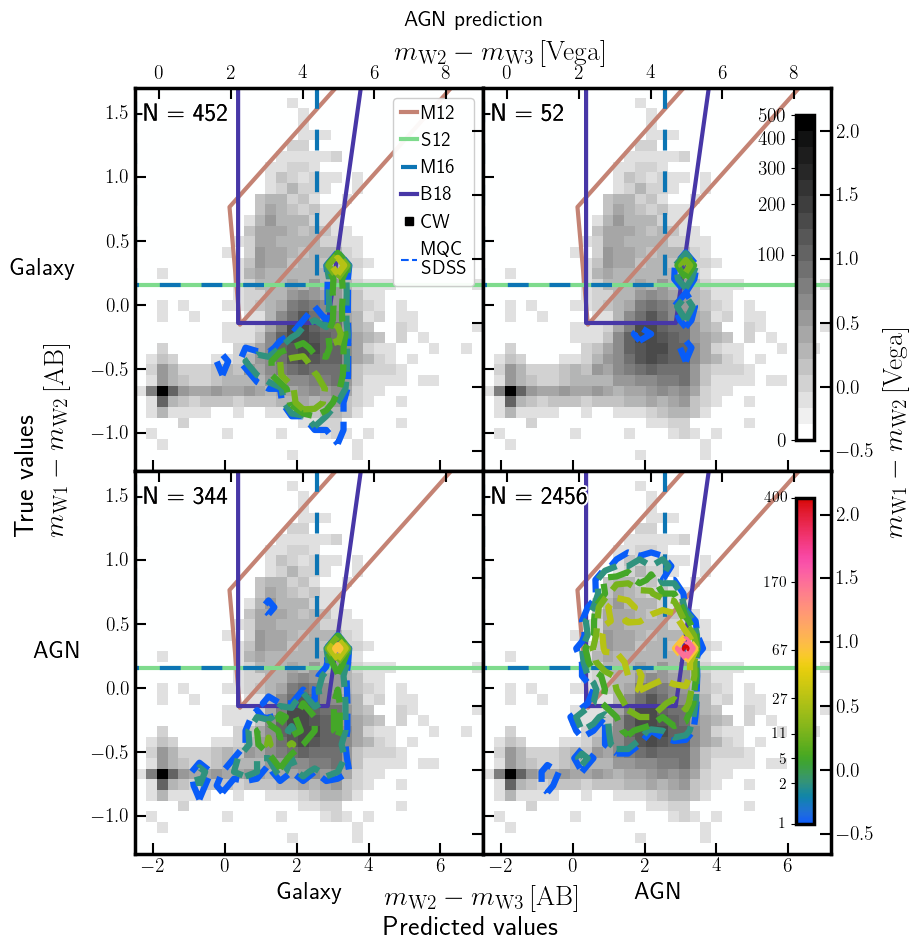

In [57]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(5 * n_cols, 5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

if discard_imputed:
    filt_colours    = np.array(full_catalog_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                      np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                      np.array(full_catalog_df.loc[:, 'W3mag'] != mag_cols_lim['W3mag'])
if not discard_imputed:
    filt_colours    = np.ones_like(full_catalog_df.loc[:, 'W1mproPM']).astype(bool)
    
if not full_dens_plot:
    filt_plot = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
                np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])
    
    dens_plot_data_x = (full_catalog_df.loc[filt_colours, 'W2mproPM'] -\
                        full_catalog_df.loc[filt_colours, 'W3mag'])[filt_plot]
    dens_plot_data_y = (full_catalog_df.loc[filt_colours, 'W1mproPM'] -\
                        full_catalog_df.loc[filt_colours, 'W2mproPM'])[filt_plot]
if full_dens_plot:
    merged_data    = pd.concat([full_catalog_df, unknown_cat_df], ignore_index=True)
    filt_colours_m = np.array(merged_data.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
                     np.array(merged_data.loc[:, 'W2mproPM']  != mag_cols_lim['W2mproPM']) &\
                     np.array(merged_data.loc[:, 'W3mag']     != mag_cols_lim['W3mag'])
    
    filt_plot      = np.isfinite(merged_data.loc[:, 'W2mproPM'] -
                                 merged_data.loc[:, 'W3mag']) &\
                     np.isfinite(merged_data.loc[:, 'W1mproPM'] -
                                 merged_data.loc[:, 'W2mproPM'])
    
    dens_plot_data_x = (merged_data.loc[filt_colours_m, 'W2mproPM'] -\
                        merged_data.loc[filt_colours_m, 'W3mag'])[filt_plot]
    dens_plot_data_y = (merged_data.loc[filt_colours_m, 'W1mproPM'] -\
                        merged_data.loc[filt_colours_m, 'W2mproPM'])[filt_plot]

dens_plts = {}
cont_plts = {}

AB_lims_x = (-2.5, 7.2)
AB_lims_y = (-1.3, 1.7)

if type_of_levels  == 'linear':
    contour_levels = np.ceil(np.linspace(0.1,\
                                 10**(np.log10(np.nanmax([dens_CM_classes[key].get_array() for
                                                                   key in dens_CM_classes if dens_CM_classes[key] != None]))),\
                                 num_contour_levels))
if type_of_levels  == 'log':
    contour_levels = np.ceil(np.logspace(np.log10(0.1),\
                                 np.log10(np.nanmax([dens_CM_classes[key].get_array() for
                                                              key in dens_CM_classes if dens_CM_classes[key] != None])),\
                                 num_contour_levels))
contour_levels = np.unique(contour_levels)
tmp_num_contour_levels = len(contour_levels)
contour_levels[tmp_num_contour_levels - 1] -= contour_levels[tmp_num_contour_levels - 1] % 10**np.floor(np.log10(contour_levels[tmp_num_contour_levels - 1]))

num_levels_dens = 20
cmap_dens = 'cet_gray_r'
cmap_cont = 'cet_CET_R3'
cmap_agn  = 'cet_CET_C9'

norm_val  = mcolors.CenteredNorm(vcenter=0.5)
norm_dens = ImageNormalize(vmin=0, vmax=500, stretch=PowerStretch(0.35))  # PowerStretch(0.35), LogStretch()
norm_cont = ImageNormalize(vmin=contour_levels[0], vmax=contour_levels[-1], stretch=PowerStretch(0.35)) # PowerStretch(0.35), LogStretch()

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density',\
                                          sharex=axs[0], sharey=axs[0])
    
    dens_plts[count] = axs[count].scatter_density(dens_plot_data_x,\
                                                  dens_plot_data_y,\
                                                  cmap=plt.get_cmap(cmap_dens, num_levels_dens), zorder=0, dpi=10,\
                                                  norm=norm_dens, alpha=1.0)
    if dens_CM_classes[count] != None:
        xx_agn = np.linspace(dens_CM_classes[count].get_extent()[0],\
                             dens_CM_classes[count].get_extent()[1], np.shape(dens_CM_classes[count].get_array())[1])
        yy_agn = np.linspace(dens_CM_classes[count].get_extent()[2],\
                             dens_CM_classes[count].get_extent()[3], np.shape(dens_CM_classes[count].get_array())[0])
        
        cont_plts[count] = axs[count].contour(xx_agn, yy_agn, np.flipud(dens_CM_classes[count].get_array()),\
                                              levels=contour_levels, linewidths=4.5, cmap=plt.get_cmap(cmap_cont),\
                                              linestyles='dashed', zorder=3, norm=norm_cont)
    n_sources   = np.sum(used_CM_filter[tuple(idx_ax)] * filt_colours * filt_exist)
    axs[count].annotate(text=f'N = {n_sources}', xy=(0.02, 0.96), xycoords='axes fraction', fontsize=18,\
                            ha='left', va='top', path_effects=gf.pe2, zorder=11)
    
    # x_Vega   = np.array(axs[0].get_xlim()) - 3.339 + 5.174  # Vega
    # y_Vega   = np.array(axs[0].get_ylim()) - 2.699 + 3.339  # Vega
    x_Vega   = np.array(AB_lims_x) - 3.339 + 5.174  # Vega
    y_Vega   = np.array(AB_lims_y) - 2.699 + 3.339  # Vega
    # Mateos+2012
    y_M12_a = 0.315 * (x_Vega) + 0.791
    y_M12_b = 0.315 * (x_Vega) - 0.222
    y_M12_c = -3.172 * (x_Vega) + 7.624
    # Stern+2012
    # Toba+2014
    # Mingo+2016
    # # Assef+2018 (75% completeness)
    # y_A18_75 = 0.530 * np.exp(0.183 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.76)**2)
    # # Assef+2018 (90% completeness)
    # y_A18_90 = 0.662 * np.exp(0.232 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.97)**2)
    # Blecha+2018
    points_M12 = np.array([[x_Vega[-1], 1.9596, 2.2501, x_Vega[-1]], [y_M12_a[-1], 1.4083, 0.4867, y_M12_b[-1]]])
    points_M16 = np.array([[4.4, 4.4, x_Vega[0], x_Vega[0]], [y_Vega[-1], 0.8, 0.8, y_Vega[-1]]])
    points_B18 = np.array([[2.2, 2.2, 4.7, (y_Vega[-1] + 8.9) * 0.5], [y_Vega[-1], 0.5, 0.5, y_Vega[-1]]])
    
    axs[count].plot(points_M12[0] + 3.339 - 5.174, points_M12[1] + 2.699 - 3.339, label='M12',\
                    c=plt.get_cmap(cmap_agn)(0.01), zorder=2, lw=3)
    axs[count].axhline(y=0.8 + 2.699 - 3.339, label='S12', c=plt.get_cmap(cmap_agn)(0.35),\
                       zorder=2, lw=3)
    axs[count].plot(points_M16[0] + 3.339 - 5.174, points_M16[1] + 2.699 - 3.339, label='M16',\
                    c=plt.get_cmap(cmap_agn)(0.6), zorder=2, lw=3, ls=(0, (5, 5)))
    axs[count].plot(points_B18[0] + 3.339 - 5.174, points_B18[1] + 2.699 - 3.339, label='B18',\
                    c=plt.get_cmap(cmap_agn)(0.75), zorder=2, lw=3)
    
    
    axs_twinx[count] = axs[count].twinx()
    # axs_twinx[count].set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339))
    # axs_twinx[count].set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
    axs_twinx[count].tick_params(which='both', top=False, right=True, direction='in')
    axs_twinx[count].tick_params(which='both', bottom=False, left=False, direction='in')
    axs_twinx[count].tick_params(axis='both', which='major', labelsize=14)
    axs_twinx[count].tick_params(which='major', length=8, width=1.5)
    axs_twinx[count].tick_params(which='minor', length=4, width=1.5)
    # axs_twinx[count].set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20)
    
    axs_twiny[count] = axs[count].twiny()
    # axs_twiny[count].set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339 + 5.174))
    # axs_twiny[count].set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
    axs_twiny[count].tick_params(which='both', top=True, right=False, direction='in')
    axs_twiny[count].tick_params(which='both', bottom=False, left=False, direction='in')
    axs_twiny[count].tick_params(axis='both', which='major', labelsize=14)
    axs_twiny[count].tick_params(which='major', length=8, width=1.5)
    axs_twiny[count].tick_params(which='minor', length=4, width=1.5)
    # axs_twiny[count].set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20)

    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

# Colorbar density
axins0 = inset_axes(axs[1], width='100%', height='100%', bbox_transform=axs[1].transAxes,\
                    loc=1, bbox_to_anchor=(0.9, 0.08, 0.05, 0.85), borderpad=0)

clb_dens    = fig.colorbar(dens_plts[1], cax=axins0, orientation='vertical',\
                 cmap=plt.get_cmap(cmap_dens, num_levels_dens), norm=norm_dens)
axins0.yaxis.set_ticks_position('left')
clb_dens.ax.tick_params(labelsize=14)
clb_dens.outline.set_linewidth(2.5)
# clb_dens.ax.set_ylabel('Elements per pixel', size=12, path_effects=pe2)
##

# Colorbar contour
axins1 = inset_axes(axs[3], width='100%', height='100%', bbox_transform=axs[3].transAxes,\
                    loc=1, bbox_to_anchor=(0.9, 0.08, 0.05, 0.85), borderpad=0)
sm = plt.cm.ScalarMappable(norm=norm_cont, cmap=cont_plts[3].cmap)
sm.set_array([])
clb_cont    = fig.colorbar(sm, cax=axins1, orientation='vertical', ticks=cont_plts[3].levels)
axins1.yaxis.set_ticks_position('left')
clb_cont.ax.tick_params(labelsize=11)
clb_cont.outline.set_linewidth(2.5)
##
    
axs[0].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap(cmap_dens)(1.1), label='CW', zorder=0)
axs[0].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap(cmap_cont)(0.0), label='MQC\nSDSS', zorder=0)
    
axs[0].set_xlim(left=AB_lims_x[0], right=AB_lims_x[1])
axs[0].set_ylim(bottom=AB_lims_y[0], top=AB_lims_y[1])
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)

plt.setp(axs_twiny[2].get_xticklabels(), visible=False)
plt.setp(axs_twiny[3].get_xticklabels(), visible=False)

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs_twinx[count].set_ylim(tuple(np.array(axs[0].get_ylim()) - 2.699 + 3.339))
    axs_twiny[count].set_xlim(tuple(np.array(axs[0].get_xlim()) - 3.339 + 5.174))

axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

axs_twinx[1].set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20, y=0.10)
axs_twiny[0].set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20, x=1.05)

axs[0].legend(loc=1, fontsize=14, ncol=1, columnspacing=.5, handletextpad=0.2, handlelength=0.8, framealpha=0.95)

fig.supxlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.46, y=0.05)
fig.supylabel('True values\n$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$', fontsize=20, x=0.09, y=0.55, va='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.55)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'WISE_colour_colour_conf_matrix_{used_classes}_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'WISE_colour_colour_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

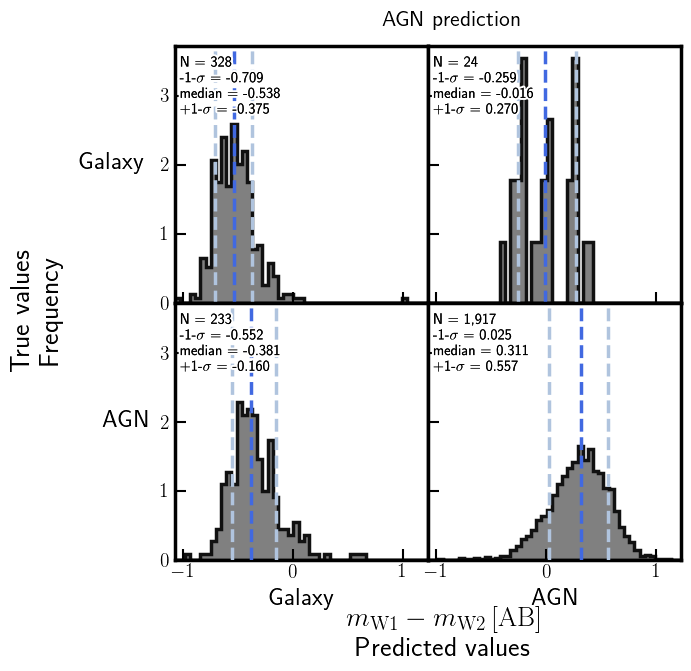

In [58]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

filt_colours = np.array(full_catalog_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W3mag'] != mag_cols_lim['W3mag'])

filt_colour  = np.array(full_catalog_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM'])

filt_plot = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
            np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])


min_bin   = (full_catalog_df.loc[:, 'W1mproPM'] -\
             full_catalog_df.loc[:, 'W2mproPM']).min()
max_bin   = (full_catalog_df.loc[:, 'W1mproPM'] -\
             full_catalog_df.loc[:, 'W2mproPM']).max()
n_bins    = 50
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_df.loc[used_CM_filter[tuple(idx_ax)] * filt_plot * filt_colour, 'W1_W2']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True)
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.02, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='left', va='top', path_effects=gf.pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'W1_W2_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'W1_W2_hist_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

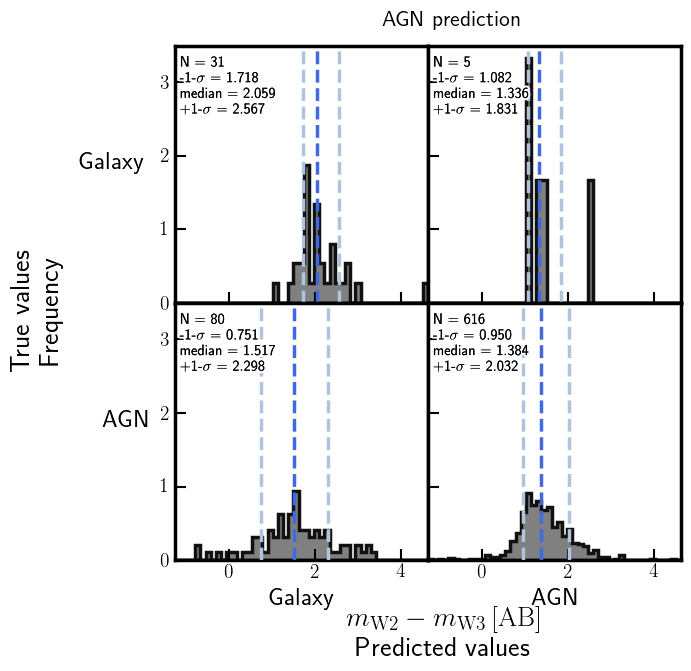

In [59]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

filt_colours = np.array(full_catalog_df.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W3mag']    != mag_cols_lim['W3mag'])

filt_colour  = np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W3mag']   != mag_cols_lim['W3mag'])

filt_plot = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
            np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])


min_bin   = (full_catalog_df.loc[:, 'W2mproPM'] -\
             full_catalog_df.loc[:, 'W3mag']).min()
max_bin   = (full_catalog_df.loc[:, 'W2mproPM'] -\
             full_catalog_df.loc[:, 'W3mag']).max()
n_bins    = 50
hist_bins = np.linspace(min_bin, max_bin, n_bins)


dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_df.loc[used_CM_filter[tuple(idx_ax)] * filt_plot * filt_colour, 'W2_W3']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True)
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.02, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='left', va='top', path_effects=gf.pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'W2_W3_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'W2_W3_hist_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

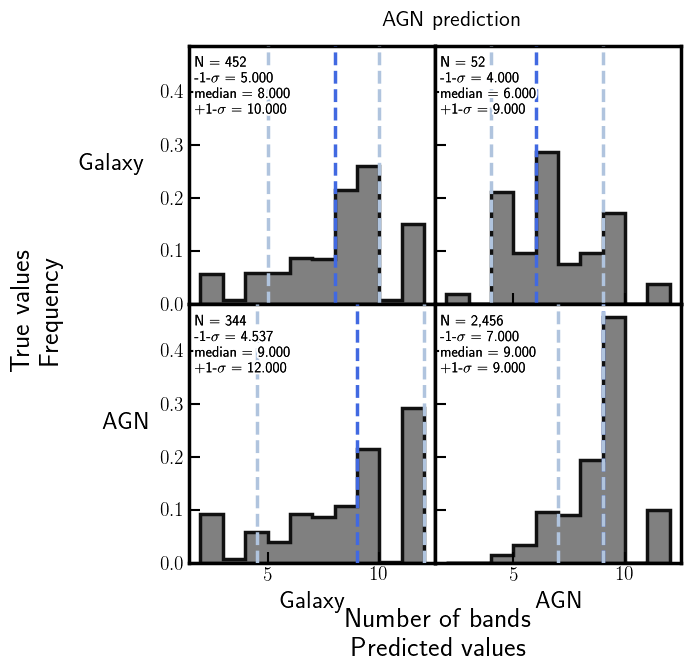

In [60]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

min_bin   = full_catalog_df.loc[:, 'band_num'].min()
max_bin   = full_catalog_df.loc[:, 'band_num'].max()
n_bins    = max_bin - min_bin + 1
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_df.loc[used_CM_filter[tuple(idx_ax)], 'band_num']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True, align='mid')
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.02, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='left', va='top', path_effects=gf.pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
# axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('Number of bands\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'band_num_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'band_num_hist_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

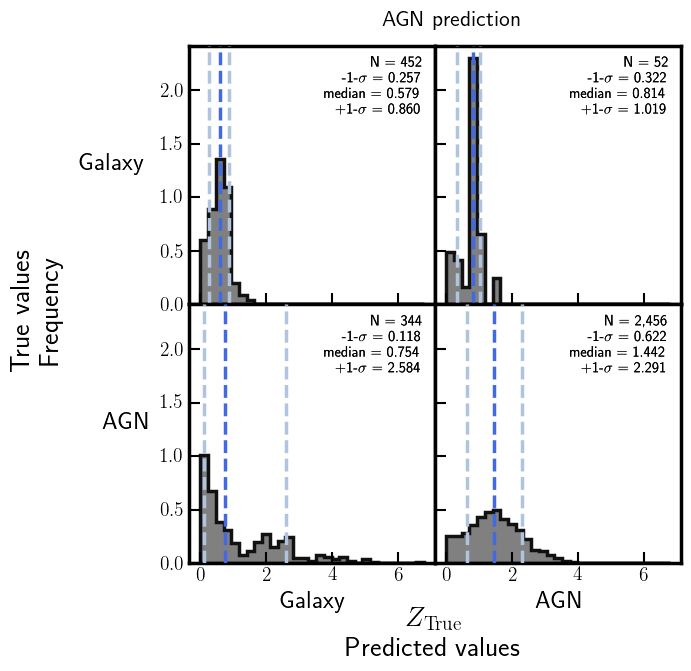

In [61]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

min_bin   = full_catalog_df.loc[:, 'Z'].min()
max_bin   = full_catalog_df.loc[:, 'Z'].max()
n_bins    = 30
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_df.loc[used_CM_filter[tuple(idx_ax)], 'Z']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True, align='mid')
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.96, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='right', va='top', path_effects=gf.pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
# axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$Z_{\mathrm{True}}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'redshift_hist_conf_matrix_{used_classes}_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'redshift_hist_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

In [62]:
cm_mat_AGN_radio_det = np.array([[np.sum(used_CM_filter[tuple([0, 0])] * np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter[tuple([0, 0])]),\
                                  np.sum(used_CM_filter[tuple([0, 1])] * np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter[tuple([0, 1])])],\
                                 [np.sum(used_CM_filter[tuple([1, 0])] * np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter[tuple([1, 0])]),\
                                  np.sum(used_CM_filter[tuple([1, 1])] * np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter[tuple([1, 1])])]])

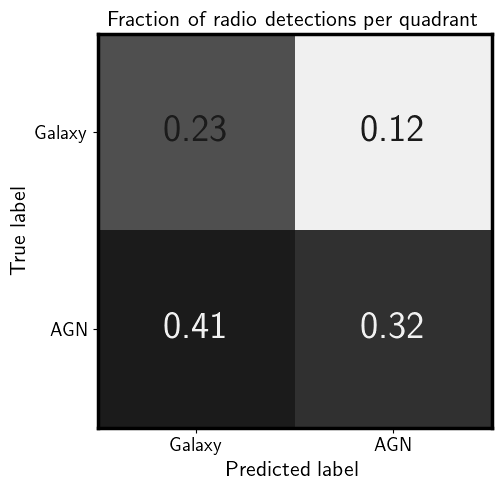

In [63]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_AGN_radio_det, 'Fraction of radio detections per quadrant', ax1,\
                 display_labels=used_labels[used_classes])
# Format numbers in cells
for text in _.texts:
    text.set_text(f'{float(text.get_text()):.2f}')

if save_plot_flag:
    save_filename = f'confusion_matrix_radio_fraction_{used_classes}_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'confusion_matrix_radio_fraction_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()